In [1]:
import pandas as pd
import numpy as np
import file_order_sim
import seaborn as sns
from importlib import reload
reload(file_order_sim)

<module 'file_order_sim' from 'c:\\Users\\robert\\OneDrive\\MSc\\p3.1 - cognitive science\\project\\repo\\data_analysis\\file_order_sim.py'>

In [2]:
# Parameters
n_scenes = 40
n_trials = n_scenes * 2
n_subjects = 50
seed = 42

In [3]:
# subjects 

prob_male = 0.7
age = (20, 38)

rng = np.random.default_rng(seed)
subjects = range(n_subjects)
ages = rng.uniform(age[0], age[1], n_subjects).astype(int)
genders = np.array(['f', 'm'] * (n_subjects // 2))
rng.shuffle(genders)

p_male = np.array([5, 8, 2, 1])
experience = rng.choice(['last-month', 'last-year', 'more', 'never'], replace=True, p=p_male/p_male.sum(), size=n_subjects)
_pos_f = np.where(genders=='f')
p_female = np.array([1, 2, 5, 4])
experience[_pos_f] = rng.choice(['last-month', 'last-year', 'more', 'never'], replace=True, p=p_female/p_female.sum(), size=len(_pos_f))

sim_success_rate = rng.beta(70, 20, n_subjects)

p_color_team = np.array([2, 3, 0.5, 6])
fav_team = rng.choice(['blue', 'red', 'both', 'neither'], replace=True, p=p_color_team/p_color_team.sum(), size=n_subjects)

p_color = np.array([1, 1, 0.25, 5])
fav_color = rng.choice(['blue', 'red', 'both', 'neither'], replace=True, p=p_color/p_color.sum(), size=n_subjects)

impaired_vision = np.zeros(n_subjects, dtype=bool)
# let's generate a dataframe for subjects, columns are subject_id, gender, age, experience
df_subjects = pd.DataFrame({'subject_id': subjects, 'gender': genders, 'age': ages, 'experience': experience, 'favorite_team': fav_team, 'favorite_color':fav_color, 'sim_psucc': sim_success_rate, 'impaired_vision':impaired_vision})
df_subjects.head()

,subject_id,gender,age,experience,favorite_team,favorite_color,sim_psucc,impaired_vision
0,0,f,33,more,blue,neither,0.758722,False
1,1,f,27,more,neither,neither,0.722582,False
2,2,f,35,more,blue,blue,0.861393,False
3,3,m,32,last-month,neither,neither,0.800888,False
4,4,m,21,last-year,blue,neither,0.770772,False


<Axes: xlabel='sim_psucc', ylabel='Count'>

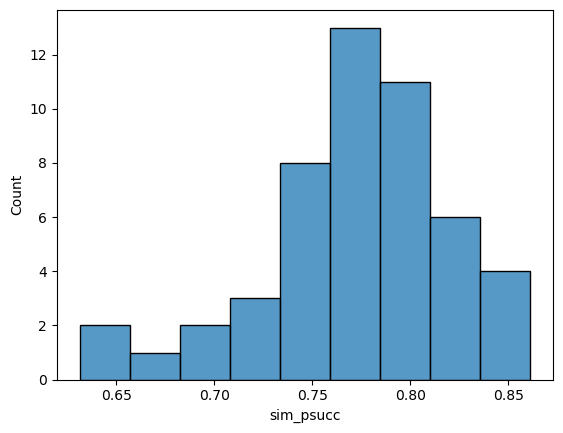

In [4]:
sns.histplot(df_subjects.sim_psucc)

,scene_id,_sim_scene_penalty
0,0,0.021817
1,1,0.023423
2,2,0.111681
3,3,0.107756
4,4,0.058470


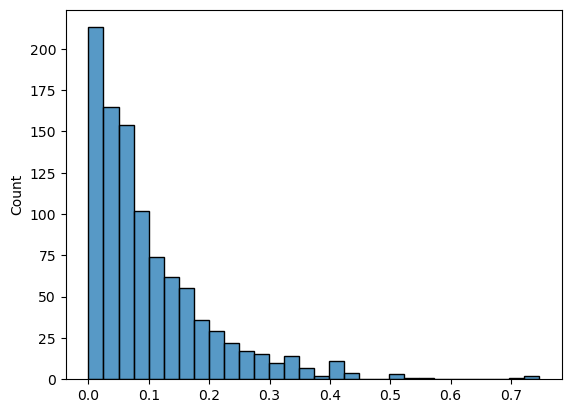

In [5]:
# scenes 

# some scenes are more difficult to answer given the time, grouping, etc
# so each scene will have a penalty on the success rate, following an exponential distribution
SCENE_PENALTY_MEAN = 0.05  # on average a X percent penalty
scene_penalty = rng.exponential(scale=SCENE_PENALTY_MEAN, size=n_scenes)
import seaborn as sns
sns.histplot(rng.exponential(scale=0.1, size=1000), bins=30)

df_scenes = pd.DataFrame({'scene_id': range(n_scenes), '_sim_scene_penalty': scene_penalty})
df_scenes.head()

In [6]:
import re
named_pattern = re.compile(r'^id(?P<scene_id>\d+)_v(?P<version>\d+)_r(?P<red_count>\d+)_b(?P<blue_count>\d+)\..+$')
assert re.match(named_pattern, 'id13_v1_r5_b6.jpg').groupdict() is not None

def generate_data(num_subjects, n_scenes, seed):
    """
    Generate synthetic data for cognitive science experiment.
    """
    data = []

    # Loop over each subject to generate filenames and create data entries
    for subj in range(num_subjects):
        filenames = file_order_sim.generate_file_list(n_scenes, seed + subj)
        for i, filename in enumerate(filenames):
            pi = re.match(named_pattern, filename).groupdict()
            scene_id = int(pi['scene_id'])
            red_count = int(pi['red_count'])
            blue_count = int(pi['blue_count'])
            trial_no = i
            
            # Append data
            data.append([subj, trial_no, filename, scene_id, red_count, blue_count])

    # Create DataFrame
    df = pd.DataFrame(data, columns=['subject_id', 'trial_no', 'filename', 'scene_id', 'red_count', 'blue_count'])
    
    # Add expected side
    conditions = [
        df['red_count'] > df['blue_count'],  # Red majority
        df['red_count'] < df['blue_count']   # Blue majority
    ]
    choices = ['red', 'blue']
    df['expected_side'] = np.select(conditions, choices, default='none')

    return df

In [7]:
# Generate the dataframe using the functions
df = generate_data(n_subjects, n_scenes, seed)
df.head()

,subject_id,trial_no,filename,scene_id,red_count,blue_count,expected_side
0,0,0,id13_v1_r5_b6.jpg,13,5,6,blue
1,0,1,id29_v1_r6_b5.jpg,29,6,5,red
2,0,2,id33_v1_r5_b6.jpg,33,5,6,blue
3,0,3,id26_v1_r6_b5.jpg,26,6,5,red
4,0,4,id21_v1_r6_b5.jpg,21,6,5,red


## Effects

In [8]:
# main effect - colour influences the correct response rate

# let's say that if the the majority team is red, the subject is 1.2 times more likely to answer correctly than otherwise
# so p_succ_red / p_succ_blue = 1.2, but we know the base success rate _sim_psucc is the average between p_succ_red and p_succ_blue
# So p_succ_red = 2*(sim_psucc - p_succ_blue/2)
# so 2*(sim_psucc - p_succ_blue/2) / p_succ_blue = 1.2
# 2 * sim_psucc/p_succ_blue - 1 = 1.2
# sim_psucc/p_succ_blue = 1.1
# p_succ_blue = sim_psucc / 1.1
# p_succ_red = 1.2 * p_succ_blue

# let's say that one average men are 20% more likely to correctly pick the majority when the majority is red
# but this degree varies, for some men, if be less likely, so the effect size per male subject is N(0.2, _sd_for_negative_pd(0.2))

# using scipy stats to calculate the standard deviation of a normal distribution of mean M such that 20% of the probability mass is bellow 0
def _sd_for_negative_pd(M, prop_bellow_0):
    import scipy.stats as stats
    z = stats.norm.ppf(prop_bellow_0)
    SD = (0 - M) / z
    return SD

male_effect_mean = 0.1
male_effect_sd = _sd_for_negative_pd(male_effect_mean, 0.2)
subject_effects_male = rng.normal(male_effect_mean, male_effect_sd, size=n_subjects)

# # some visualisation
# sns.histplot(rng.normal(male_effect_mean, _sd_for_negative_pd(male_effect_mean, 0.1), size=1000))
# # add a vertical line at 0
# from matplotlib import pyplot as plt
# plt.axvline(0, 0, 1, color='red')

female_effect_mean = 0 
subject_effects_female = rng.normal(female_effect_mean, male_effect_sd*0.5, size=n_subjects)

subject_effects = subject_effects_male
subject_effects[_pos_f] = subject_effects_female[_pos_f]

# subject_effects

# # perform a one sided t-test to check if the mean of subject_effects is greater than 0
# from scipy.stats import ttest_1samp
# ttest_1samp(subject_effects, 0)

## given how much more likely the percentage offset, we can now calculate p_succ_red and p_succ_blue for each subject
#p_succ_blue = df.apply(lambda row: row.sim_psucc / (1 + subject_effects[row.subject_id]/2), axis=1)
p_succ_blue = df_subjects.sim_psucc / (1 + subject_effects[df_subjects.subject_id]/2)
#p_succ_red = df.reset_index().apply(lambda row: (1 + subject_effects[row.subject_id]) * p_succ_blue[row['index']], axis=1)
p_succ_red = (1 + subject_effects[df_subjects.subject_id]) * p_succ_blue

# check that p_succ_blue and p_succ_red have been calculated correctly
assert np.abs((p_succ_red + p_succ_blue) / 2 - df_subjects.sim_psucc).sum() < 1e-14

df_subjects['_sim_psucc_blue'] = p_succ_blue
df_subjects['_sim_psucc_red'] = p_succ_red

<Axes: ylabel='Count'>

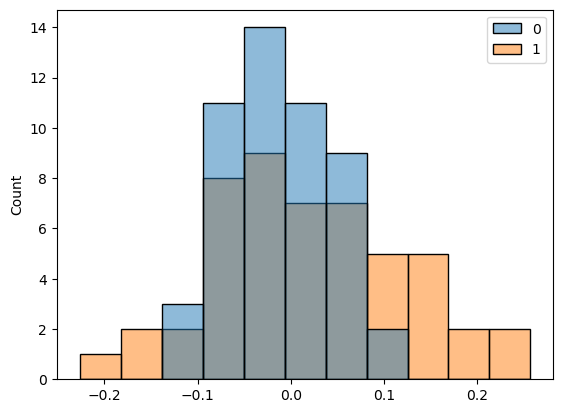

In [9]:
sns.histplot([subject_effects_female, subject_effects_male])

## Final dataframe

In [10]:
# join df with df_subjects and df_scenes
df_merged = df.merge(df_subjects, on='subject_id')
df_merged = df_merged.merge(df_scenes, on='scene_id')
df_merged.head()

,subject_id,trial_no,filename,scene_id,red_count,blue_count,expected_side,gender,age,experience,favorite_team,favorite_color,sim_psucc,impaired_vision,_sim_psucc_blue,_sim_psucc_red,_sim_scene_penalty
0,0,0,id13_v1_r5_b6.jpg,13,5,6,blue,f,33,more,blue,neither,0.758722,False,0.737228,0.780215,0.069004
1,0,41,id13_v2_r5_b6.jpg,13,5,6,blue,f,33,more,blue,neither,0.758722,False,0.737228,0.780215,0.069004
2,1,28,id13_v1_r6_b5.jpg,13,6,5,red,f,27,more,neither,neither,0.722582,False,0.748480,0.696684,0.069004
3,1,61,id13_v2_r6_b5.jpg,13,6,5,red,f,27,more,neither,neither,0.722582,False,0.748480,0.696684,0.069004
4,2,33,id13_v1_r5_b6.jpg,13,5,6,blue,f,35,more,blue,blue,0.861393,False,0.812889,0.909897,0.069004


In [11]:
# add a response time column to the dataframe
# now let's refine the reponse time so that each subject has a sliglty different mean and standard deviation
# the per subject mean is sampled from a normal distribution with mean 1000 and sd 100
# the per subject standard deviation is sampled from a normal distribution with mean 100 and sd 10

subject_mean = np.abs(np.random.normal(1000, 100, size=n_subjects))
subject_std = np.abs(np.random.normal(100, 10, size=n_subjects))
df_merged['response_time'] = df_merged.apply(lambda row: np.abs(np.random.normal(subject_mean[row.subject_id], subject_std[row.subject_id])), axis=1)

In [12]:
psucc_new = df_merged._sim_psucc_red.to_numpy()
_pos_blue = np.where(df_merged['expected_side']=='blue')[0]
psucc_new[_pos_blue] = df_merged._sim_psucc_blue[_pos_blue]

df_merged['_sim_psucc_color'] = np.clip(psucc_new, 0, 1)

<Axes: ylabel='Count'>

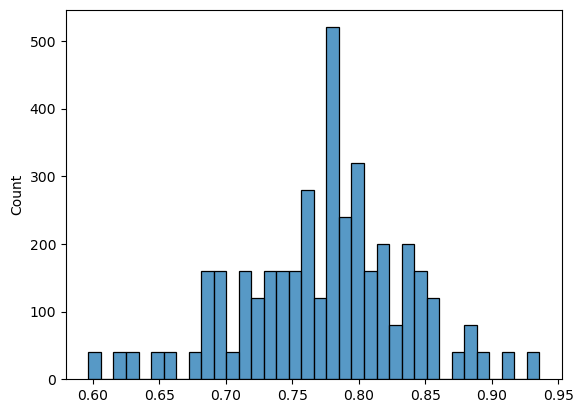

In [13]:
sns.histplot(psucc_new)

In [14]:
# now applying the scene penalty and the _sim_psucc_multiplier to get the probability of correct answer for each trial
df_merged['sim_psucc'] = df_merged.apply(lambda row: row._sim_psucc_color - row._sim_scene_penalty, axis=1)

## Learning effect

In [15]:
# Response time linearly decreases from 1 to 0.7
rt_scaling = np.linspace(1.0, 0.8, n_trials)
df_merged['response_time'] = df_merged.apply(lambda row: row.response_time * rt_scaling[row.trial_no], axis=1)

# sim_psucc increasing from 0.X to 1.0 in the first 10 images
psucc_scaling = np.ones(n_trials) 
psucc_scaling[:10] = np.linspace(0.8, 1.0, 10)
df_merged['sim_psucc'] = df_merged.apply(lambda row: row.sim_psucc * psucc_scaling[row.trial_no], axis=1)

df_merged.head()

,subject_id,trial_no,filename,scene_id,red_count,blue_count,expected_side,gender,age,experience,favorite_team,favorite_color,sim_psucc,impaired_vision,_sim_psucc_blue,_sim_psucc_red,_sim_scene_penalty,response_time,_sim_psucc_color
0,0,0,id13_v1_r5_b6.jpg,13,5,6,blue,f,33,more,blue,neither,0.534579,False,0.737228,0.737228,0.069004,1004.261435,0.737228
1,0,41,id13_v2_r5_b6.jpg,13,5,6,blue,f,33,more,blue,neither,0.668224,False,0.737228,0.737228,0.069004,929.709359,0.737228
2,1,28,id13_v1_r6_b5.jpg,13,6,5,red,f,27,more,neither,neither,0.627681,False,0.748480,0.696684,0.069004,828.292162,0.696684
3,1,61,id13_v2_r6_b5.jpg,13,6,5,red,f,27,more,neither,neither,0.627681,False,0.748480,0.696684,0.069004,814.552586,0.696684
4,2,33,id13_v1_r5_b6.jpg,13,5,6,blue,f,35,more,blue,blue,0.743885,False,0.812889,0.812889,0.069004,1188.578942,0.812889


## Picking answers based on the the probability of success (sim_psucc)

In [16]:
# finally let's provide the answered_side
def _other_side(side):
    return 'red' if side == 'blue' else 'blue'

df_merged['response_side'] = df_merged.apply(lambda row: row.expected_side if rng.binomial(1, row.sim_psucc) else _other_side(row.expected_side), axis=1)
df_merged

,subject_id,trial_no,filename,scene_id,red_count,blue_count,expected_side,gender,age,experience,favorite_team,favorite_color,sim_psucc,impaired_vision,_sim_psucc_blue,_sim_psucc_red,_sim_scene_penalty,response_time,_sim_psucc_color,response_side
0,0,0,id13_v1_r5_b6.jpg,13,5,6,blue,f,33,more,blue,neither,0.534579,False,0.737228,0.737228,0.069004,1004.261435,0.737228,red
1,0,41,id13_v2_r5_b6.jpg,13,5,6,blue,f,33,more,blue,neither,0.668224,False,0.737228,0.737228,0.069004,929.709359,0.737228,blue
2,1,28,id13_v1_r6_b5.jpg,13,6,5,red,f,27,more,neither,neither,0.627681,False,0.748480,0.696684,0.069004,828.292162,0.696684,red
3,1,61,id13_v2_r6_b5.jpg,13,6,5,red,f,27,more,neither,neither,0.627681,False,0.748480,0.696684,0.069004,814.552586,0.696684,blue
4,2,33,id13_v1_r5_b6.jpg,13,5,6,blue,f,35,more,blue,blue,0.743885,False,0.812889,0.812889,0.069004,1188.578942,0.812889,blue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,47,56,id16_v2_r5_b6.jpg,16,5,6,blue,m,25,last-year,neither,neither,0.687983,False,0.720926,0.720926,0.032943,1013.894167,0.720926,red
3996,48,24,id16_v1_r6_b5.jpg,16,6,5,red,m,32,last-month,red,blue,0.766153,False,0.685338,0.799096,0.032943,809.701125,0.799096,red
3997,48,61,id16_v2_r6_b5.jpg,16,6,5,red,m,32,last-month,red,blue,0.766153,False,0.685338,0.799096,0.032943,735.232904,0.799096,red
3998,49,7,id16_v1_r6_b5.jpg,16,6,5,red,m,22,more,neither,red,0.774468,False,0.741962,0.843433,0.032943,877.865780,0.843433,red


In [17]:
# if the expeted side is blue the response time increases by aprox 10%. The actual increase value is normal around 10% with std of 1%
df_merged['response_time'] = df_merged.apply(lambda row: row.response_time * np.random.normal(1.1, 0.01) if row.expected_side == 'blue' else row.response_time, axis=1)

In [18]:
# add a column so that each scene has a response_time factor uniformly sampled between 0.8 and 1.2
df_merged['response_time'] = df_merged.apply(lambda row: row.response_time * np.random.uniform(0.8, 1.2), axis=1)

In [19]:
# round the age to full years
df_merged['age'] = df_merged.age.apply(lambda x: int(x))

In [20]:
# save two versions of the dataframe one with ground truth, one without
cols_to_keep = ['subject_id', 'filename', 'trial_no', 'gender', 'age', 'experience', 'response_time', 'response_side', 'favorite_team', 'favorite_color', 'impaired_vision']
df_merged.drop(columns = [col for col in df_merged.columns if col not in cols_to_keep]).to_csv('synthetic.csv', index=None)

df_merged.drop(columns = [col for col in df_merged.columns if col not in cols_to_keep + ['sim_psucc']]).to_csv('synthetic_gt.csv', index=None)

df_merged.to_csv('synthetic_full.csv', index=None)
